In [1]:
from datetime import datetime
import warnings
import os

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from get_model_training_data_05 import get_features_and_data

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, features, next_month) = get_features_and_data()

training examples = 2256, testing examples = 251


<Axes: xlabel='prob_of_release', ylabel='Count'>

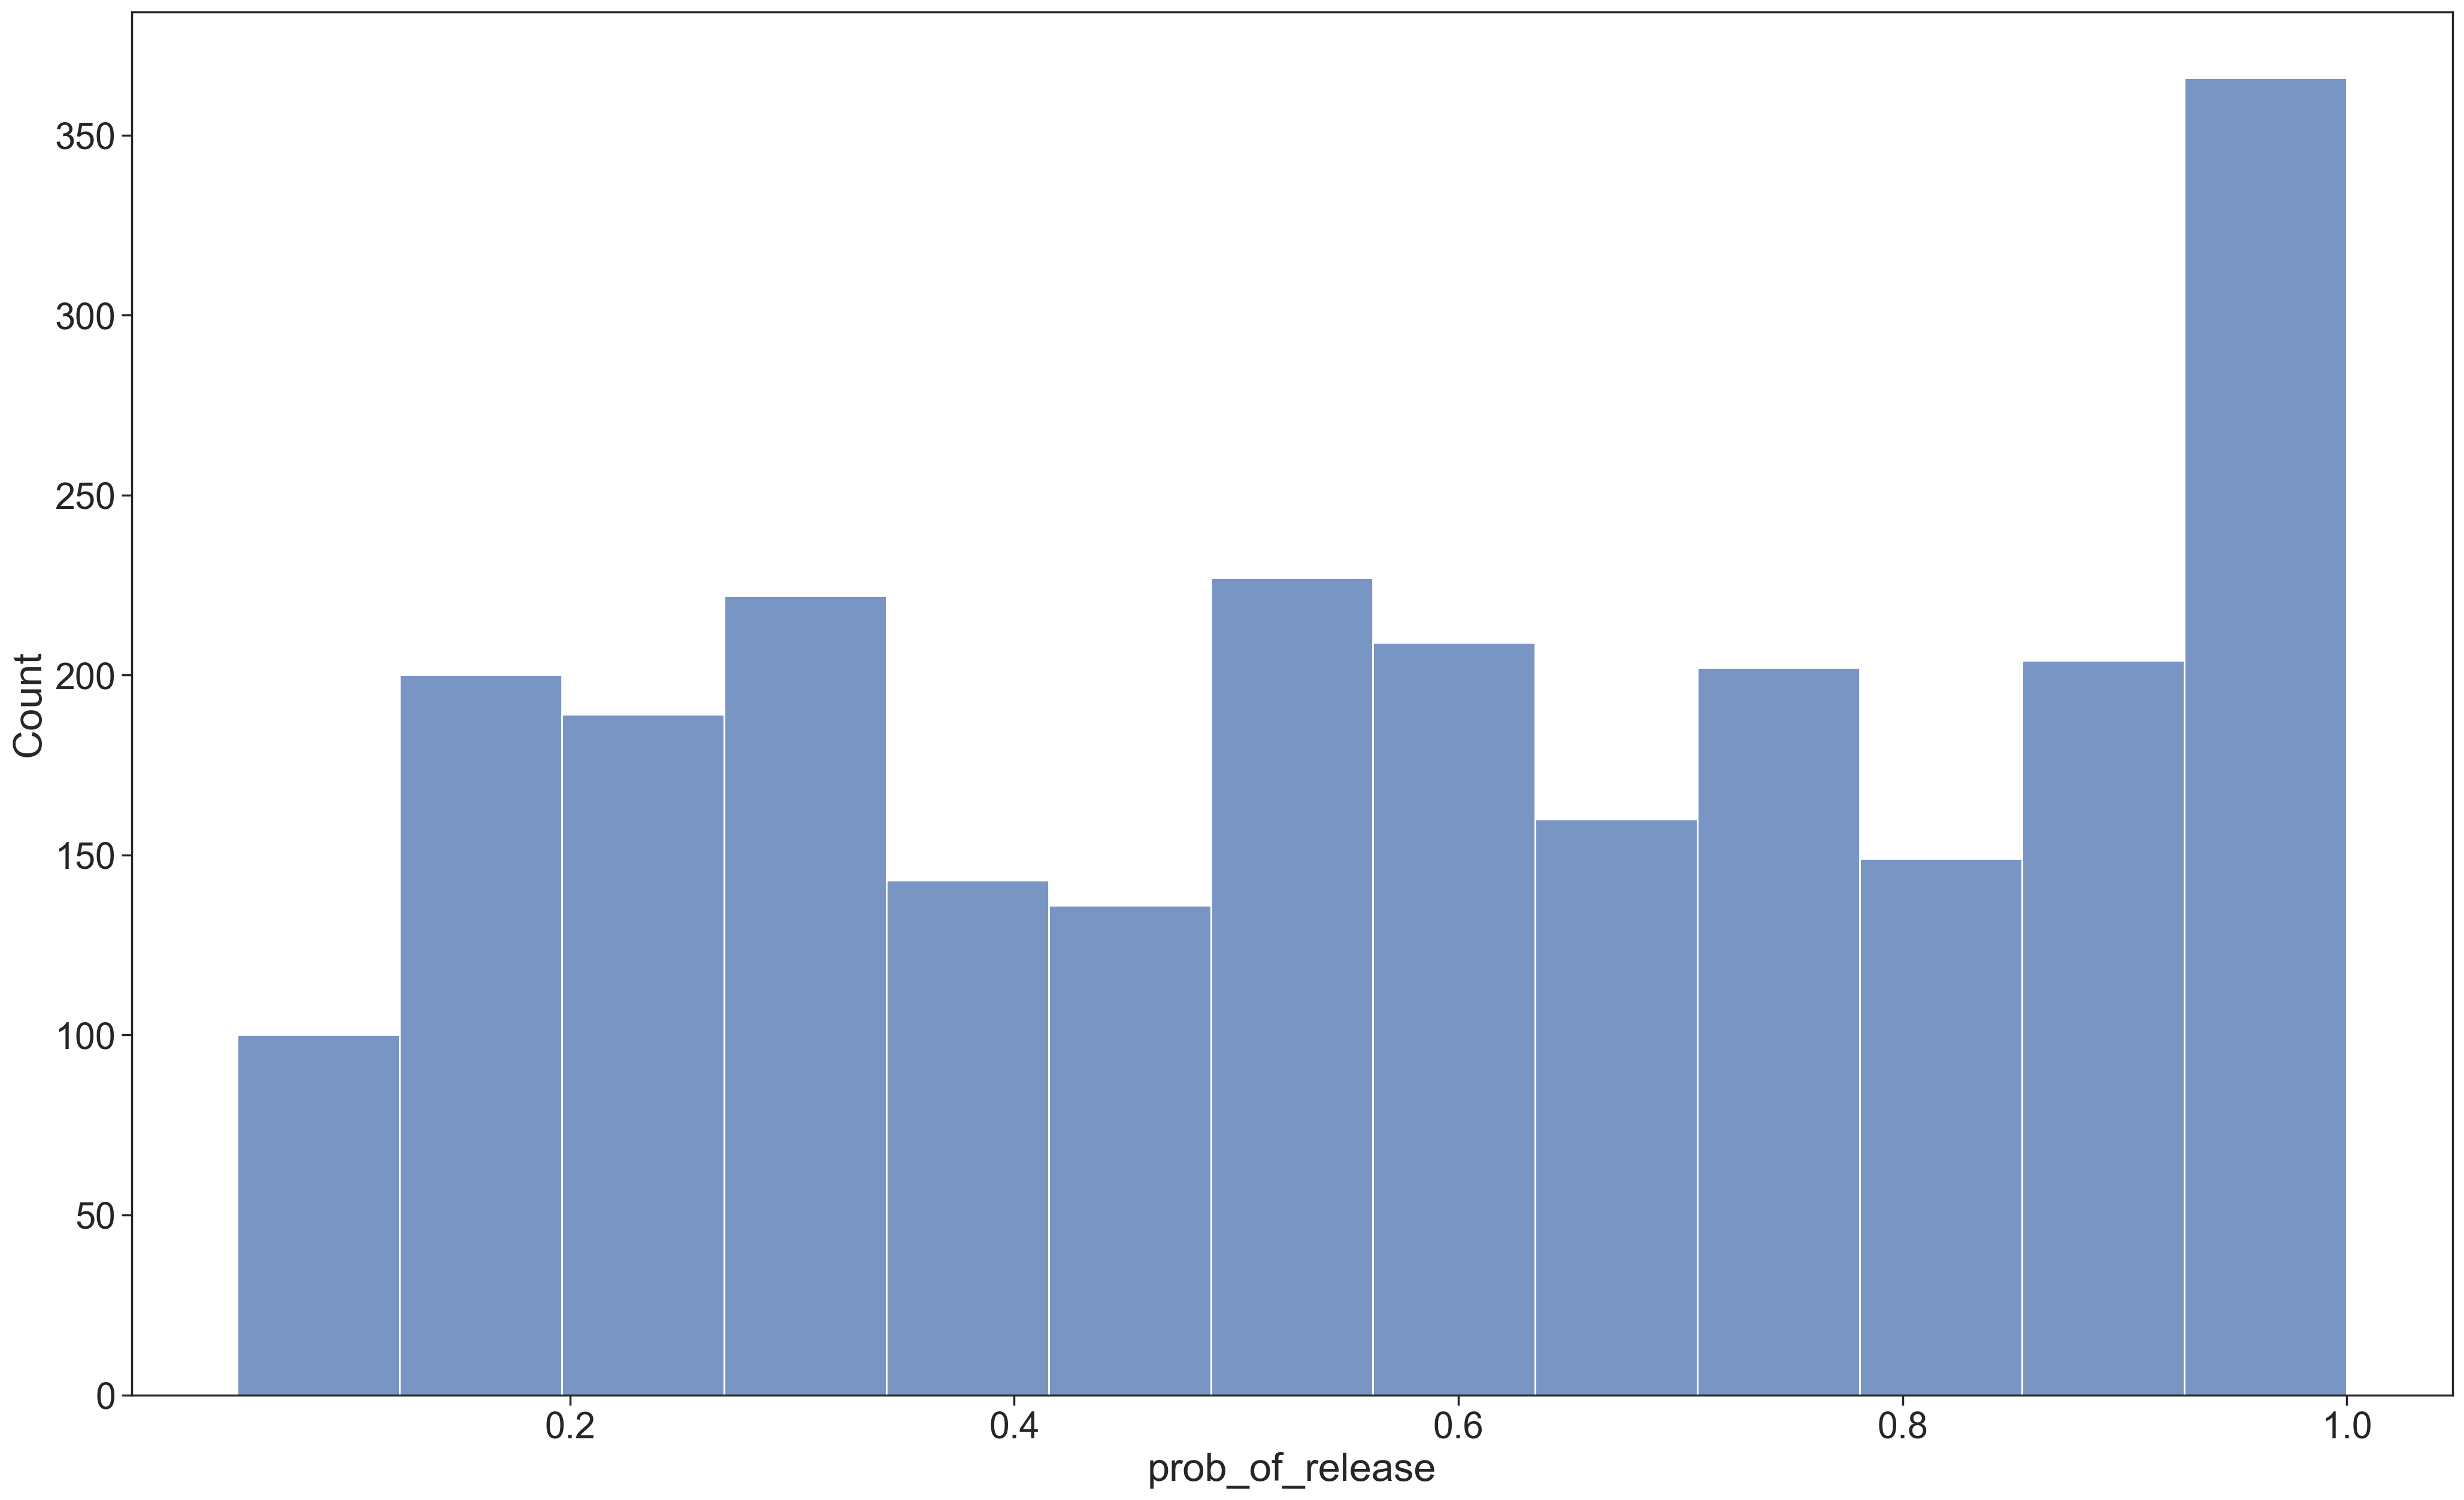

In [3]:
sns.histplot(x=df["prob_of_release"])

<Axes: xlabel='binary_target', ylabel='Count'>

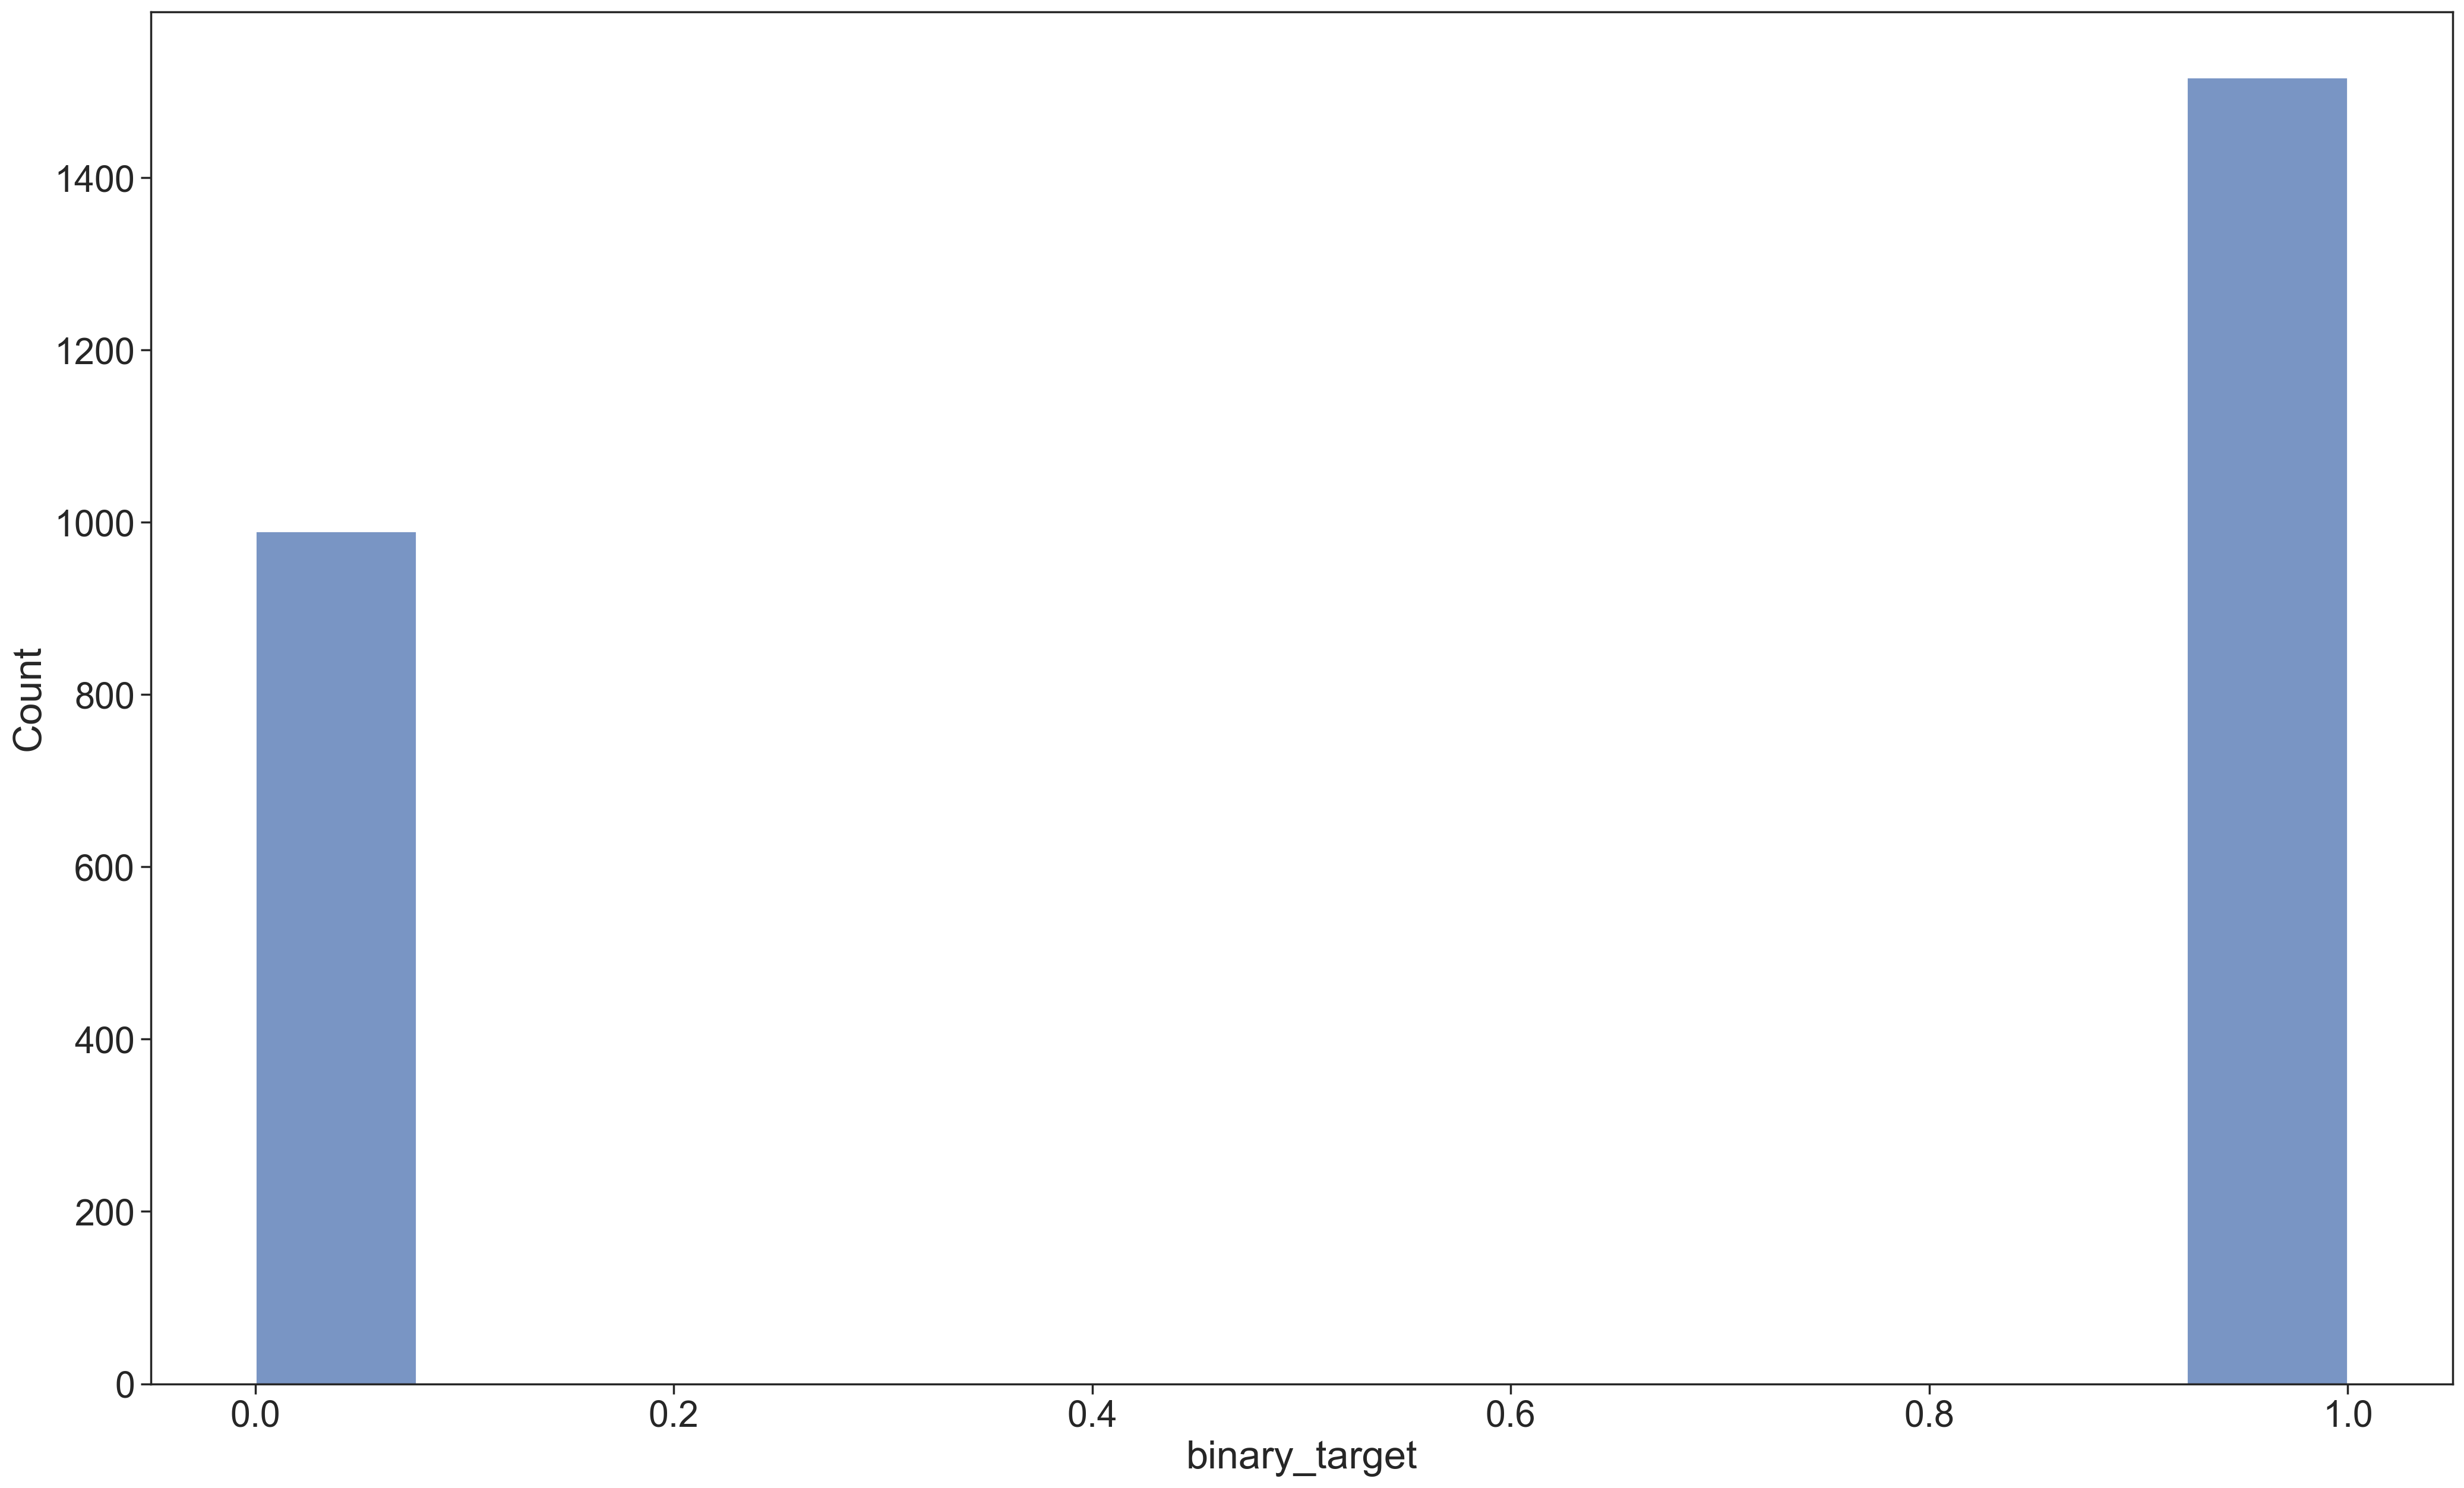

In [4]:
sns.histplot(x=df["binary_target"])

In [5]:
# sns.barplot(data=df, x="month_holidays", y="prob_of_release")

## Model-Building and Evaluation

In [6]:
def train_model(train_df):
    ct = ColumnTransformer(remainder="passthrough",
                           transformers=[
                               ("ss", StandardScaler(), ["days_since_previous_release", "month_holidays"])])

    pipeline = Pipeline(
        [("ct", ct), ("lr", LogisticRegression(random_state=1024, class_weight="balanced"))])
    
    model = GridSearchCV(
        pipeline,
        param_grid={"lr__penalty" : [None, "l1", "l2", "elasticnet"],
                    "lr__C" : np.logspace(-3, 3, 7),
                    "lr__solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
                    "lr__l1_ratio" : [0.00001, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
        scoring="f1", cv=3, refit=True)

    model.fit(train_df[features], train_df["binary_target"])
    
    return model

In [7]:
model = train_model(train_df)

In [8]:
model.best_params_

{'lr__C': 0.1,
 'lr__l1_ratio': 0.5,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga'}

In [9]:
model.best_score_

0.8309061797311436

In [10]:
sorted(zip(model.best_estimator_.feature_names_in_, model.best_estimator_["lr"].coef_[0]),
       key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 2.7519756312227908),
 ('M_Sep', 0.24887486001510686),
 ('WD_Tuesday', 0.123390243164199),
 ('month_holidays', 0.11603299111699926),
 ('WD_Monday', 0.09913832904183016),
 ('M_Jul', 0.0637294292035216),
 ('M_Jan', 0.034118628915736166),
 ('WD_Friday', 0.0),
 ('WD_Sunday', 0.0),
 ('WD_Wednesday', 0.0),
 ('M_Apr', 0.0),
 ('M_Aug', 0.0),
 ('M_Jun', 0.0),
 ('M_May', 0.0),
 ('M_Nov', 0.0),
 ('M_Oct', 0.0),
 ('WD_Thursday', -0.00428813426237631),
 ('M_Dec', -0.025694029235954725),
 ('WD_Saturday', -0.06831103549585514),
 ('M_Feb', -0.12332128026249761),
 ('previous_release_post', -0.12622968513407262),
 ('M_Mar', -0.1530905082051661)]

In [11]:
test_df["predicted_binary"] = model.predict(test_df[features])

In [12]:
tp = len(test_df.query('binary_target == 1 & predicted_binary == 1'))
fp = len(test_df.query('binary_target != 1 & predicted_binary == 1'))
fn = len(test_df.query('binary_target == 1 & predicted_binary != 1'))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

(round(precision, 4), round(recall, 4))

(0.958, 0.7081)

In [13]:
test_df[["predicted_0", "predicted_prob"]] = model.predict_proba(test_df[features])
del test_df["predicted_0"]

In [14]:
mape(test_df["prob_of_release"], test_df["predicted_prob"])

0.33555966533774245

In [15]:
test_df["residuals"] = test_df["predicted_prob"] - test_df["prob_of_release"]
# sns.scatterplot(data=test_df, x="predicted_prob", y="residuals", s=75)

In [16]:
test_df[["index", "prob_of_release", "predicted_prob", "residuals"]].sort_values(by=["residuals"])

,index,prob_of_release,predicted_prob,residuals
2373,2023-08-18,1.000000,0.134618,-0.865382
2507,2023-12-30,1.000000,0.135332,-0.864668
2336,2023-07-12,1.000000,0.154873,-0.845127
2352,2023-07-28,1.000000,0.154873,-0.845127
2457,2023-11-10,1.000000,0.173593,-0.826407
...,...,...,...,...
2345,2023-07-21,0.642857,0.984655,0.341797
2341,2023-07-17,0.357143,0.713609,0.356467
2344,2023-07-20,0.571429,0.965118,0.393689
2343,2023-07-19,0.500000,0.923272,0.423272


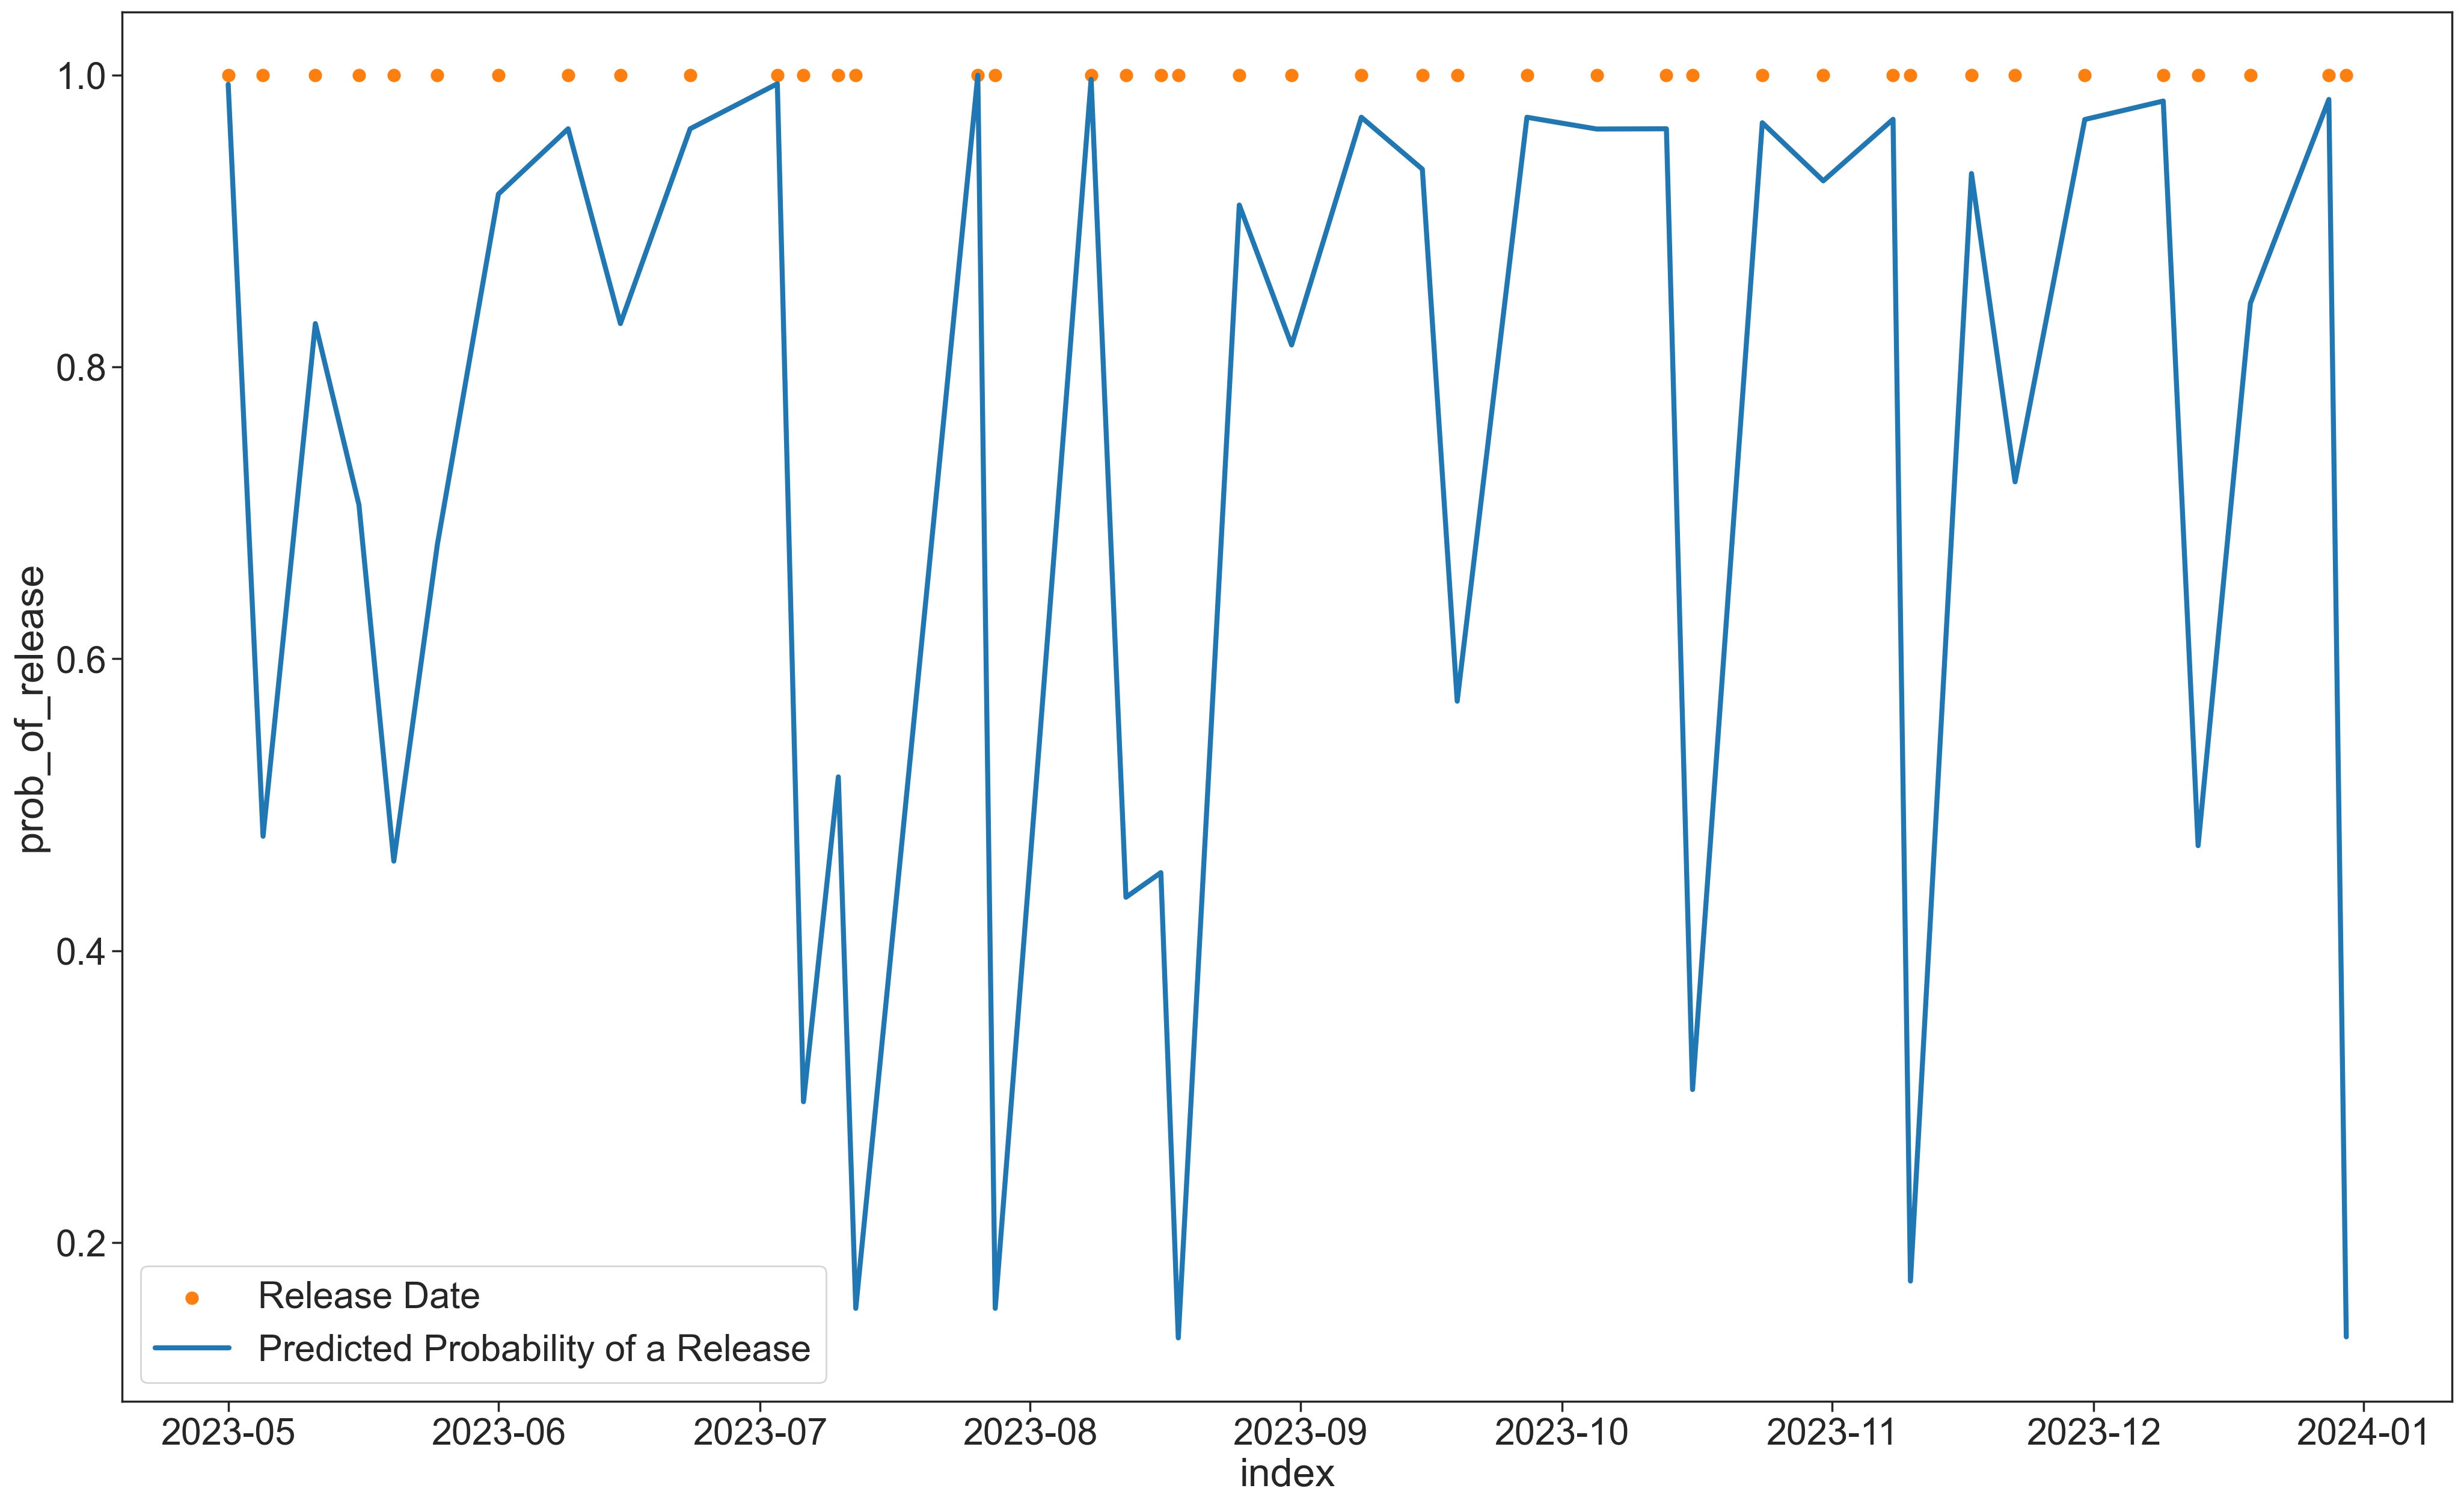

In [17]:
ax = sns.scatterplot(data=test_df[test_df["prob_of_release"] == 1], x="index", y="prob_of_release",
                     label="Release Date", s=75, color="tab:orange")
sns.lineplot(data=test_df[test_df["prob_of_release"] == 1], x="index", y="predicted_prob", ax=ax,
             label="Predicted Probability of a Release", color="tab:blue", linewidth=3)
plt.show()

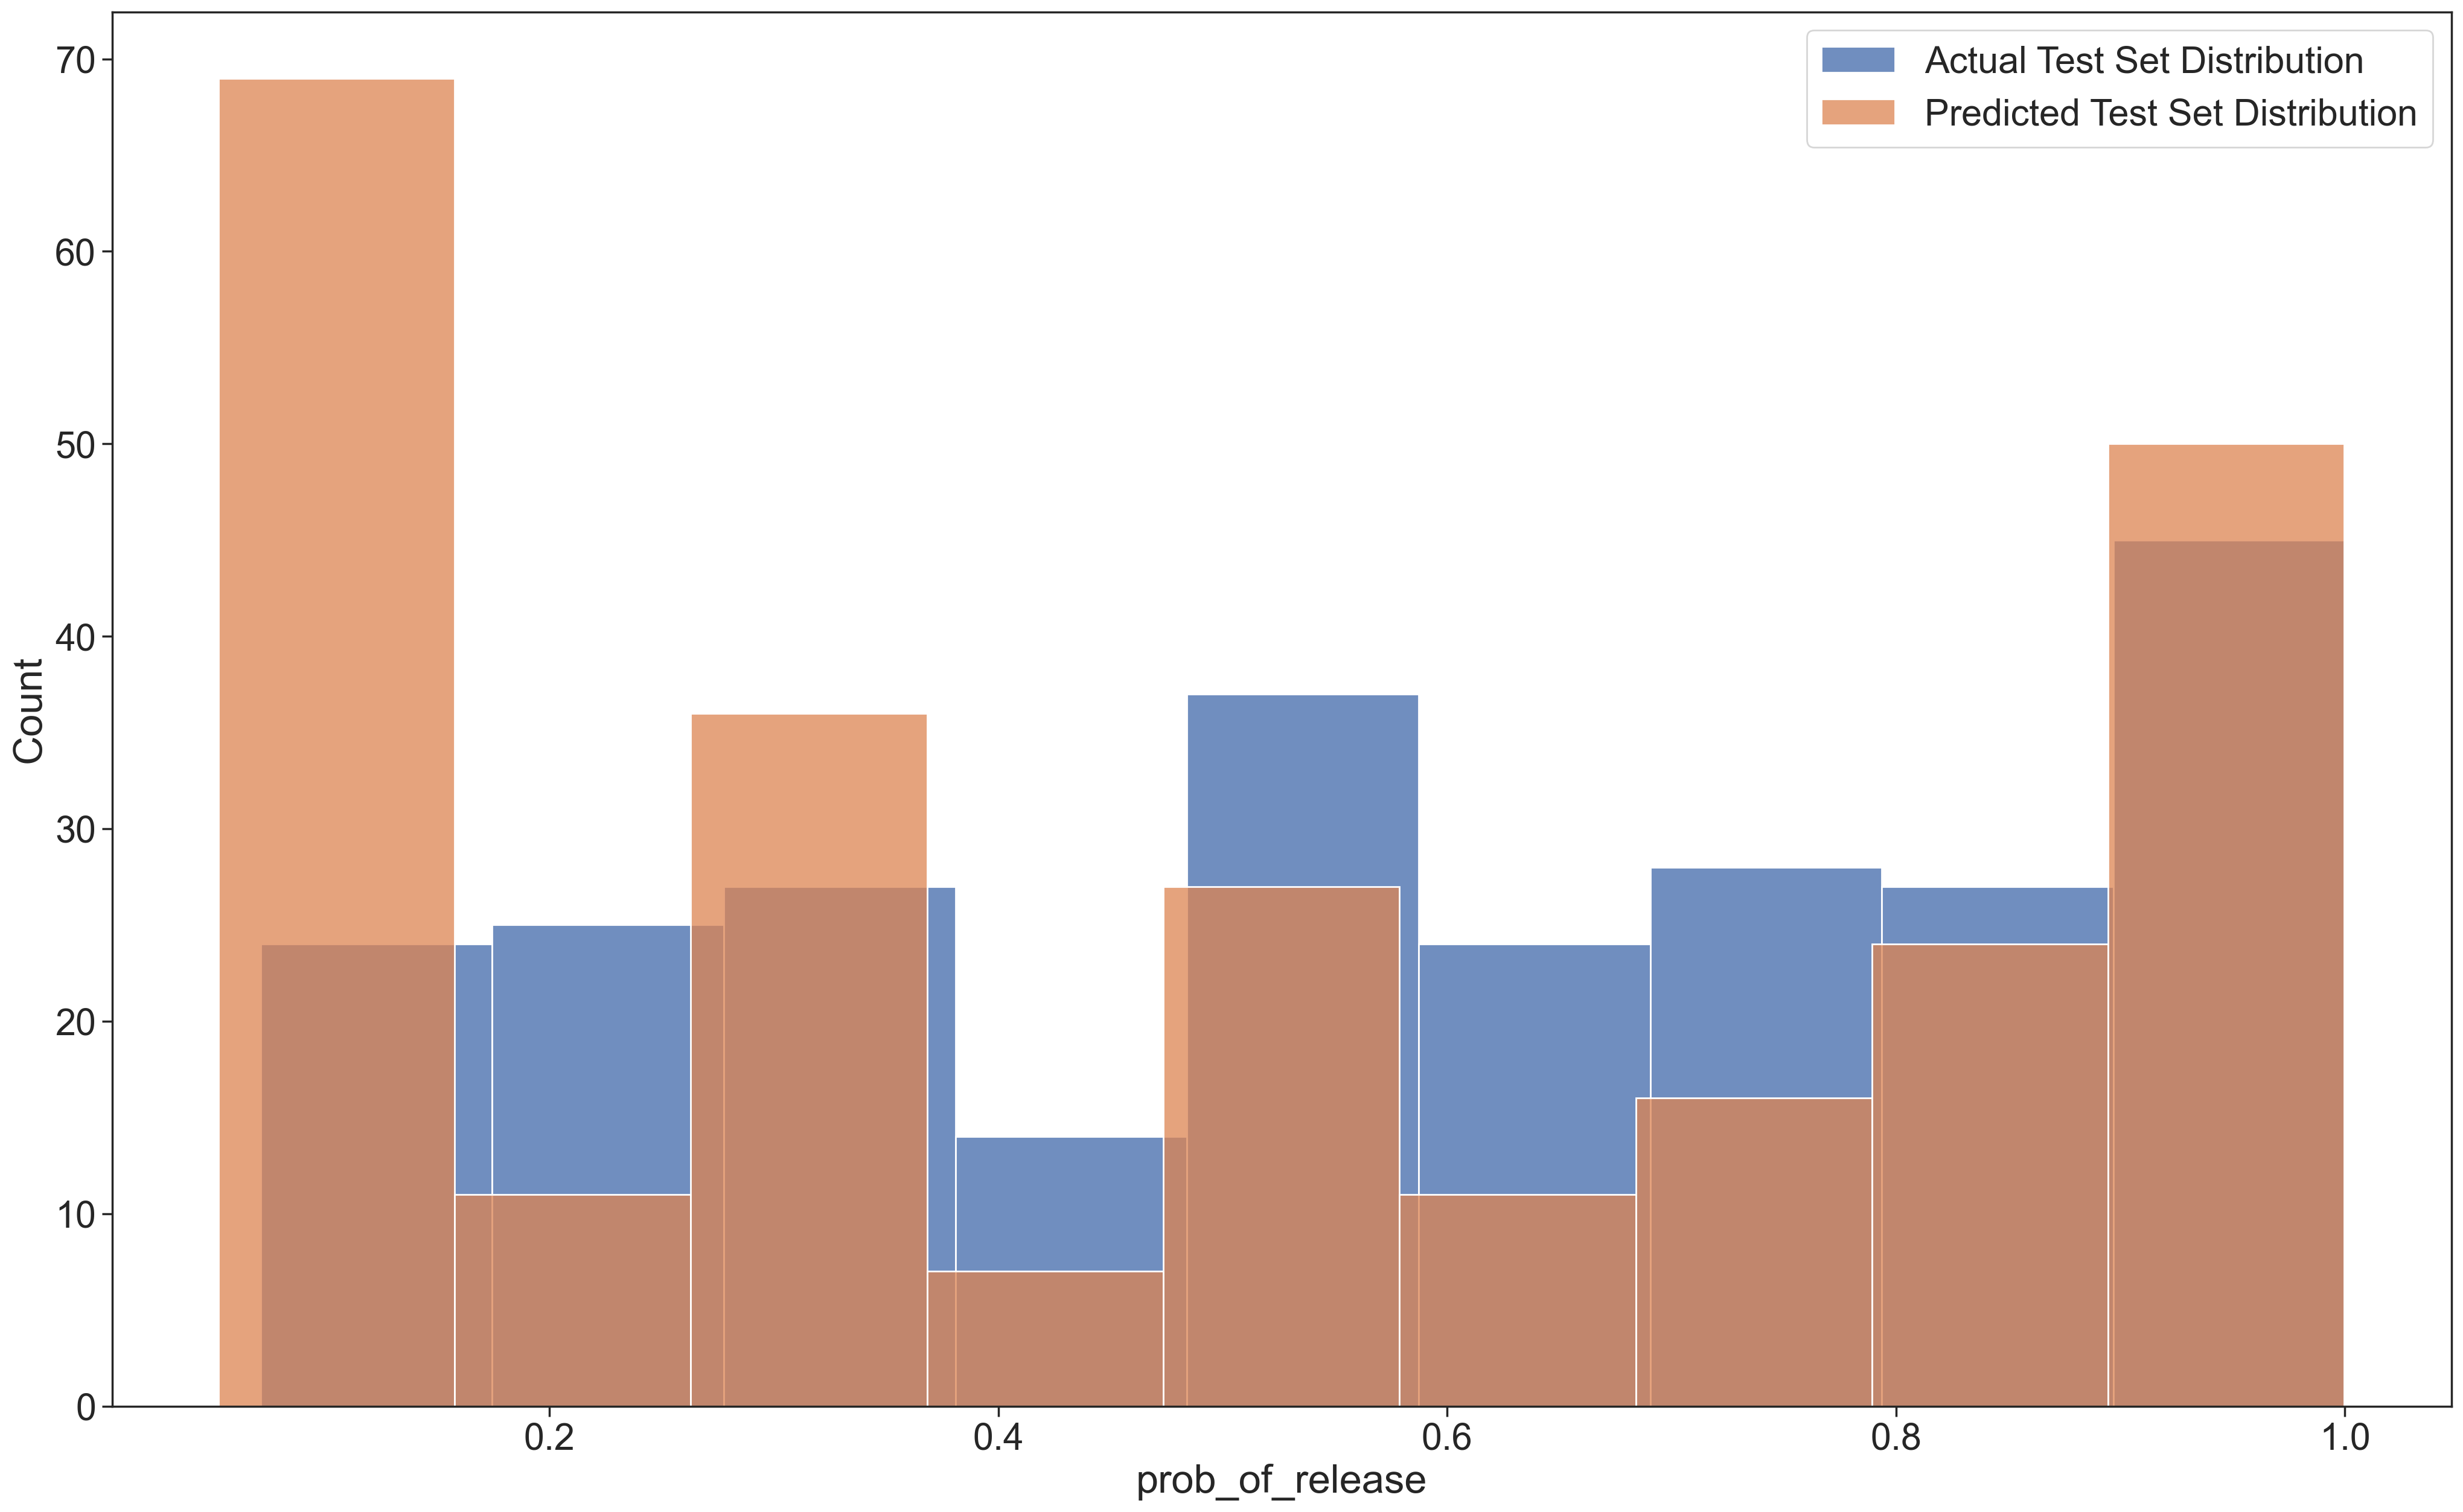

In [18]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["predicted_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


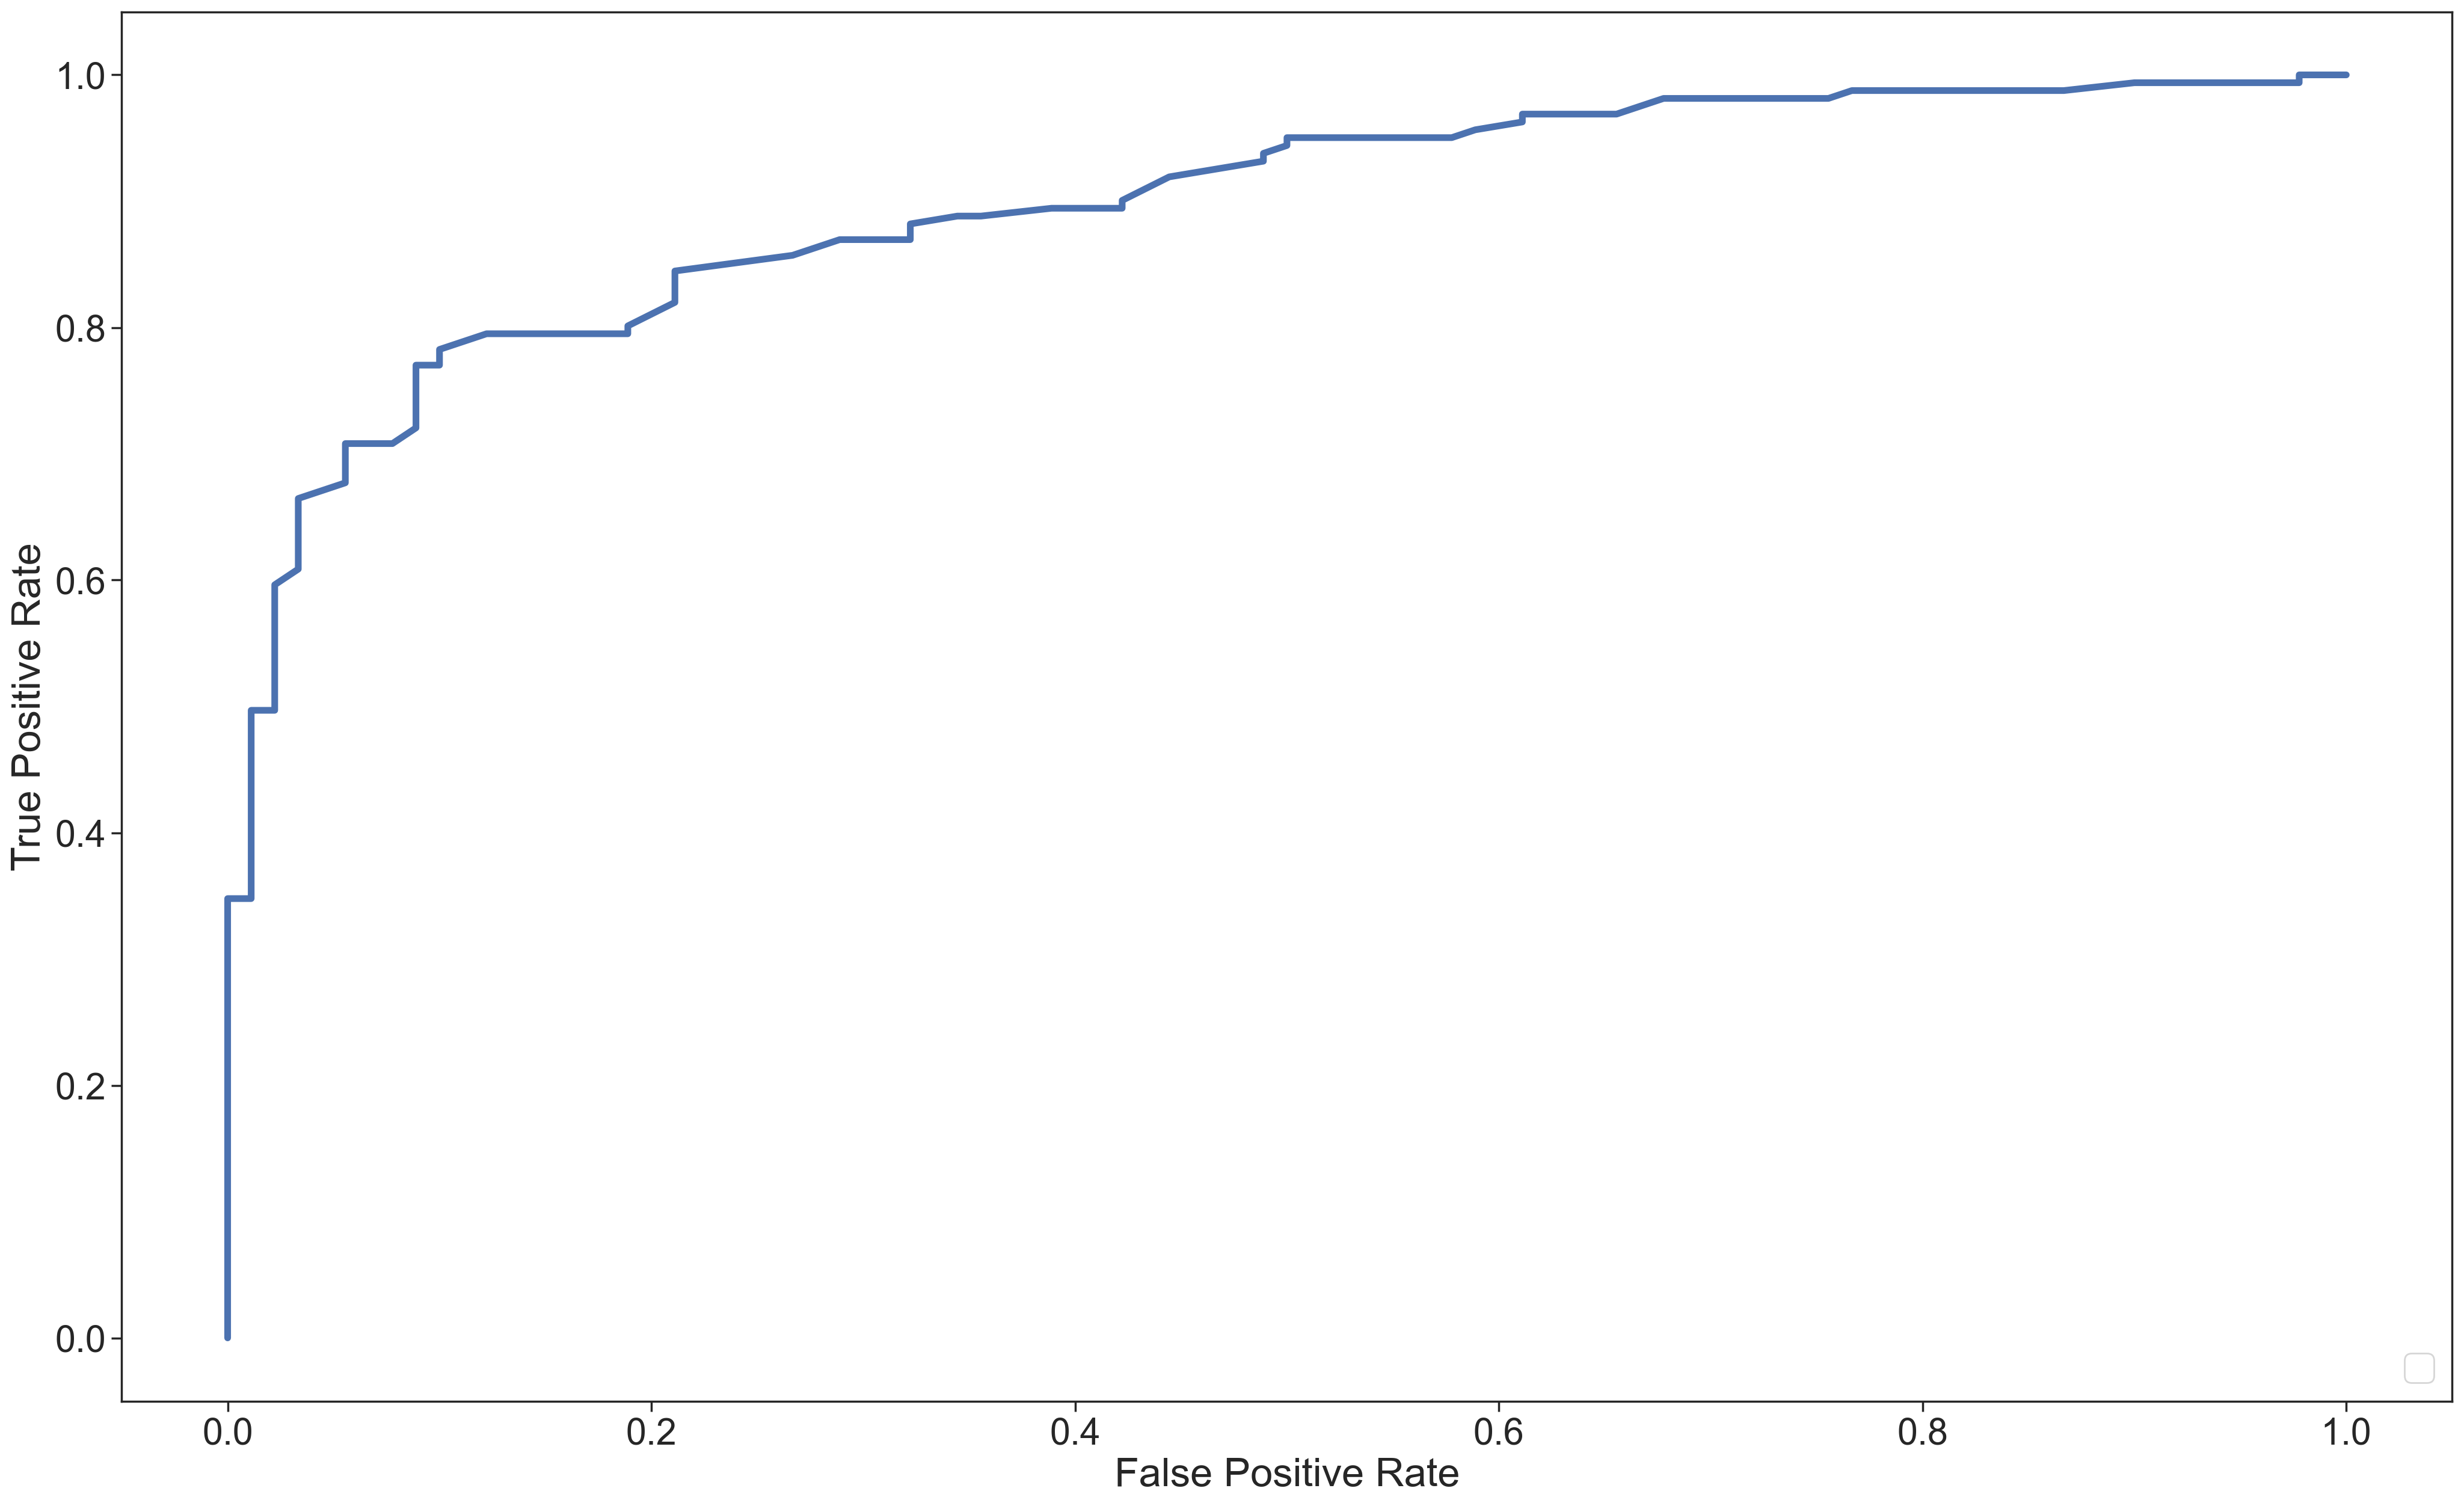

In [19]:
fp_rate, tp_rate, thresholds = roc_curve(test_df["binary_target"], test_df["predicted_prob"], pos_label=1)
RocCurveDisplay(fpr=fp_rate, tpr=tp_rate).plot(linewidth=4)
# sns.lineplot(x=thresholds, y=tp_rate)

## Predictions for the Next Month

In [20]:
model = train_model(df)

In [21]:
# based on https://machinelearningmastery.com/prediction-intervals-for-machine-learning/

sum_errs = np.sum((df["prob_of_release"] - model.predict_proba(df[features])[:, 1]) ** 2)
stdev = np.sqrt(1 / (len(df["prob_of_release"]) - 2) * sum_errs)
stdev

0.22832216988684453

In [22]:
next_month["predicted_binary"] = model.predict(next_month[features])

In [23]:
next_month["predicted_prob"] = model.predict_proba(next_month[features])[:, 1]

In [24]:
next_month["predicted_min"] = next_month["predicted_prob"] - (1.96 * stdev)
next_month["predicted_min"] = next_month["predicted_min"].apply(lambda x : 0 if x < 0 else x)
next_month["predicted_max"] = next_month["predicted_prob"] + (1.96 * stdev)
next_month["predicted_max"] = next_month["predicted_max"].apply(lambda x : 1 if x > 1 else x)

In [25]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max", "predicted_binary"]]

,index,predicted_min,predicted_prob,predicted_max,predicted_binary
1,2023-12-31,0.000000,0.035658,0.483170,0
2,2024-01-01,0.000000,0.203942,0.651453,0
3,2024-01-02,0.000000,0.396603,0.844114,0
4,2024-01-03,0.130591,0.578103,1.000000,1
5,2024-01-04,0.304448,0.751960,1.000000,1
6,2024-01-05,0.447323,0.894834,1.000000,1
7,2024-01-06,0.497571,0.945083,1.000000,1
8,2024-01-07,0.532698,0.980209,1.000000,1
9,2024-01-08,0.546669,0.994180,1.000000,1
10,2024-01-09,0.550212,0.997724,1.000000,1


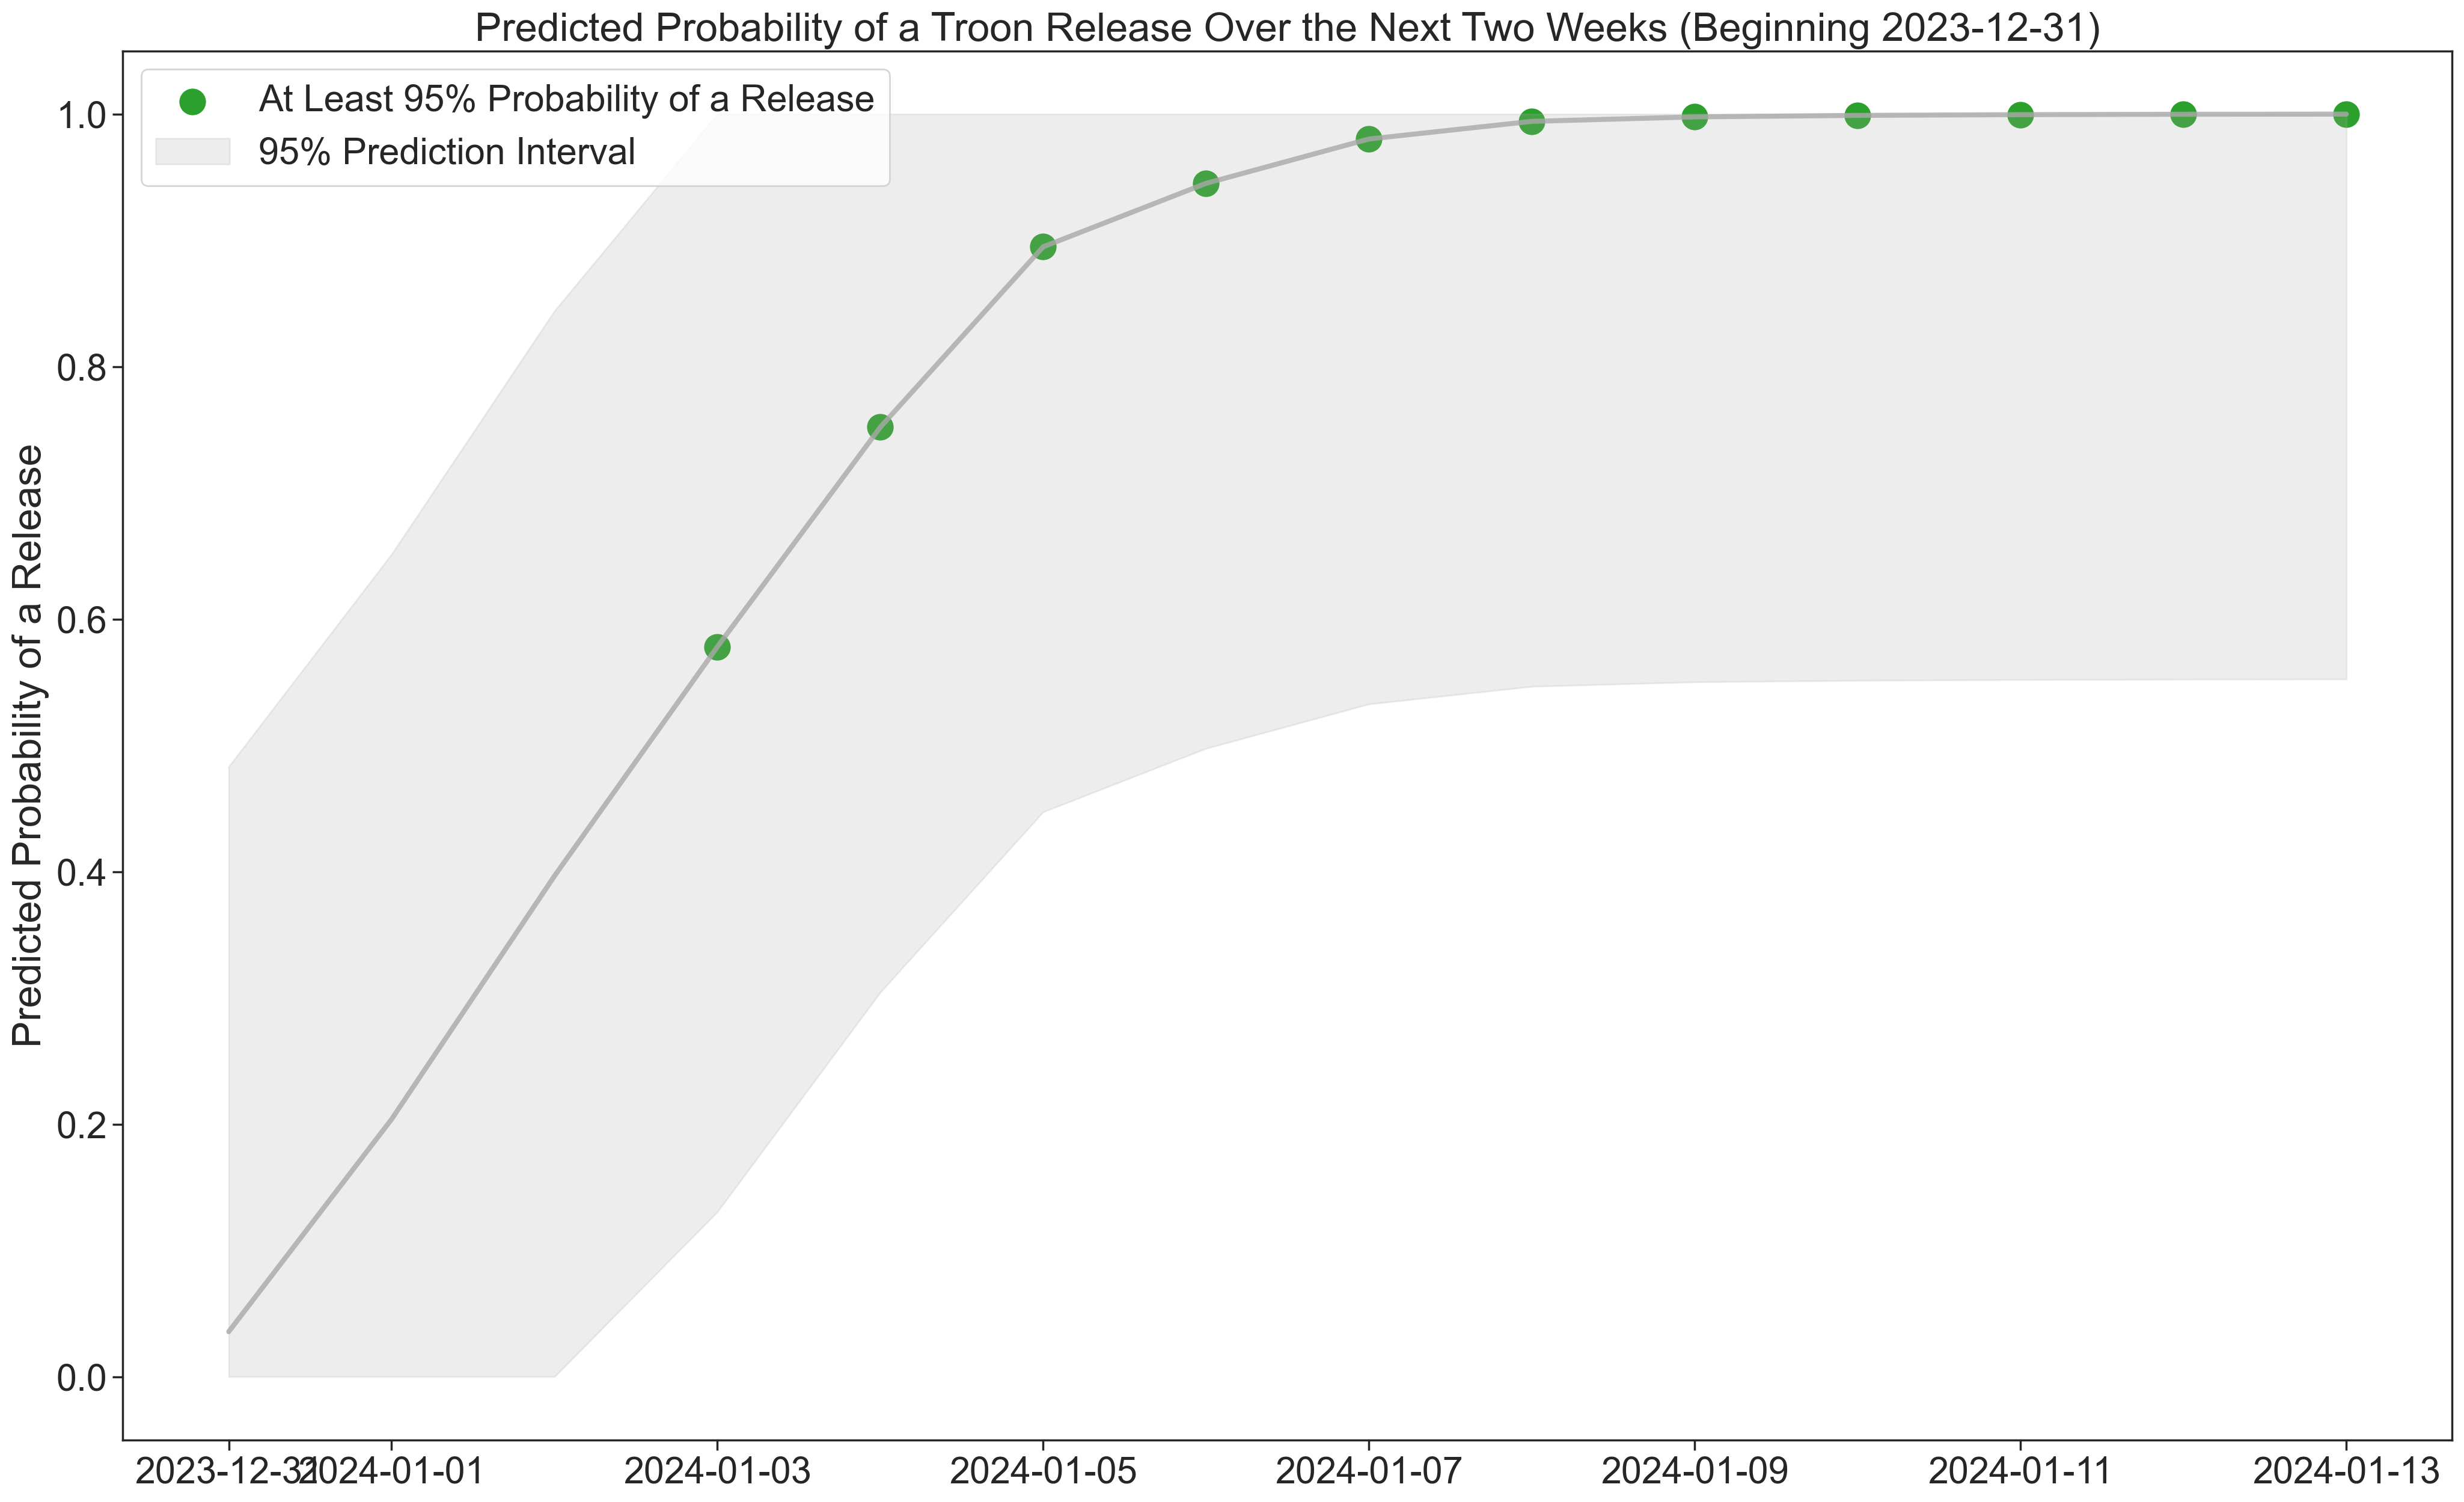

In [26]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 95% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% Prediction Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()